Reference: https://programminghistorian.org/en/lessons/linear-regression#overview-of-linear-regression

# Installing required packages

In [32]:
!pip install pandas scikit-learn seaborn matplotlib

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/c7/8b/92e9da1f28310a1f6572b5c55097b0c0ceb5e27486d85fb73b54f5a9b939/matplotlib-3.10.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached matplotlib-3.10.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/67/71/1e6e95aee21a500415f5d2dbf037bf4567529b6a4e986594d7026ec5ae90/contourpy-1.3.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached contourpy-1.3.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d9529

# Importing required packages

In [24]:
import os
import pandas as pd
from datetime import date as dt
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Loading metadata file

In [25]:
data_directory = "corpus"
metadata_file = "metadata_file1.csv"
df = pd.read_csv(metadata_file)

In [26]:
len(df)

3218

In [27]:
df

,cluster_id,day,month,nyt_id,nyt_pdf_endpoint,perceived_author_gender,xml_id,year,yearDecimal,filename
0,none,7,1,4fc03b9245c1498b0d1e86aa,https://timesmachine.nytimes.com/timesmachine/...,none,101702107,1905,1905.016438,4fc03b9245c1498b0d1e86aa.csv
1,none,7,1,4fc0532945c1498b0d250e4c,https://timesmachine.nytimes.com/timesmachine/...,m,101702142,1905,1905.016438,4fc0532945c1498b0d250e4c.csv
2,none,7,1,4fc045fc45c1498b0d2162b6,https://timesmachine.nytimes.com/timesmachine/...,m,101702170,1905,1905.016438,4fc045fc45c1498b0d2162b6.csv
3,none,7,1,4fc0532945c1498b0d250e51,https://timesmachine.nytimes.com/timesmachine/...,none,101702169,1905,1905.016438,4fc0532945c1498b0d250e51.csv
4,none,7,1,4fc03b9245c1498b0d1e86ad,https://timesmachine.nytimes.com/timesmachine/...,m,101702168,1905,1905.016438,4fc03b9245c1498b0d1e86ad.csv
...,...,...,...,...,...,...,...,...,...,...
3213,3,17,10,4fc0934a45c1498b0d37d0e6,https://timesmachine.nytimes.com/timesmachine/...,none,113314527,1920,1920.792350,4fc0934a45c1498b0d37d0e6-3.csv
3214,4,17,10,4fc0934a45c1498b0d37d0e6,https://timesmachine.nytimes.com/timesmachine/...,m,113314527,1920,1920.792350,4fc0934a45c1498b0d37d0e6-4.csv
3215,5,17,10,4fc0934a45c1498b0d37d0e6,https://timesmachine.nytimes.com/timesmachine/...,m,113314527,1920,1920.792350,4fc0934a45c1498b0d37d0e6-5.csv
3216,6,17,10,4fc0934a45c1498b0d37d0e6,https://timesmachine.nytimes.com/timesmachine/...,m,113314527,1920,1920.792350,4fc0934a45c1498b0d37d0e6-6.csv


# List of dictionaries

## Creating a list of term-count dictionaries of the book reviews

In [28]:
list_of_dictionaries = []
for row in df.iterrows():
    file_path = os.path.join(data_directory, row[1]['filename'])
    temp_df = pd.read_csv(file_path).dropna().reset_index(drop=True).set_index('term')
    mydict = temp_df['count'].to_dict()
    list_of_dictionaries.append(mydict)

len(list_of_dictionaries)

3218

## Select the top 10000 terms in the book reviews

In [29]:
def top_words(number, list_of_dicts):
    totals = {}
    for d in list_of_dicts:
        for k,v, in d.items():
            try:
                totals[k] += v
            except:
                totals[k] = v
    totals = Counter(totals)
    return [i[0] for i in totals.most_common(number)]

def cull_list_of_dicts(term_list, list_of_dicts):
    results = []
    for d in list_of_dicts:
        result = {}
        for term in term_list:
            try:
                result[term] = d[term]
            except:
                pass
        results.append(result)
    return results

top_term_list = top_words(10000, list_of_dictionaries)
new_list_of_dicts = cull_list_of_dicts(top_term_list, list_of_dictionaries)

In [32]:
len(list_of_dictionaries[0]) - len(new_list_of_dicts[0])

16

## Convert to document-term matrix

In [34]:
dictionary_vectorizer = DictVectorizer()
document_term = dictionary_vectorizer.fit_transform(new_list_of_dicts)

## TF-IDF transformation

In [35]:
tfidf = TfidfTransformer()
tfidf_vectors = tfidf.fit_transform(document_term)

Select the best 5000 features using f_regression, f-regression is a univariate feature selection method that selects the best features based on the correlation between the feature and the target.

In [36]:
tfidf_vectors_new = SelectKBest(f_regression, k=5000).fit_transform(tfidf_vectors, df['yearDecimal'])

## Train-test split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors_new, df['yearDecimal'], test_size=0.33, random_state=31)

## Linear regression model training

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## Predictions and evaluation

In [41]:
results = lr.predict(X_test)

In [42]:
print(f"R2 score: {r2_score(list(y_test), list(results))}")

R2 score: 0.43580413188459255


In [16]:
def r_square_scratch(true, predicted):
    # substract each predicted value from each true
    residuals = [a - b for a, b in zip(true, predicted)]
    # calculate the sum of squared differences between predicted and true
    mss = sum([i**2 for i in residuals])
    # calculate the mean true value
    mean_true = (sum(true))/len(true)
    # calculate the sum of squared differences of each true value minus the mean true value
    tss = sum([(i-mean_true)**2 for i in true])
    # calculate final r2 value
    return 1-(mss/tss)

In [43]:
results_df = pd.DataFrame()
results_df['predicted'] = list(results)
results_df['actual'] = list(y_test)
results_df['residual'] = results_df['predicted'] - results_df['actual']
results_df = results_df.sort_values(by='residual').reset_index(drop=True)
results_df.describe()

,predicted,actual,residual
count,1062.000000,1062.000000,1062.000000
mean,1914.885758,1914.999911,-0.114153
std,8.347274,8.111314,6.091579
min,1892.098521,1905.016438,-20.247316
25%,1908.792748,1905.802740,-4.122677
50%,1914.947973,1914.928767,-0.144013
75%,1921.098159,1923.606164,3.956387
max,1937.171827,1925.986301,19.662131


Text(0.5, 1.0, 'Histogram of Linear Regression Residuals')

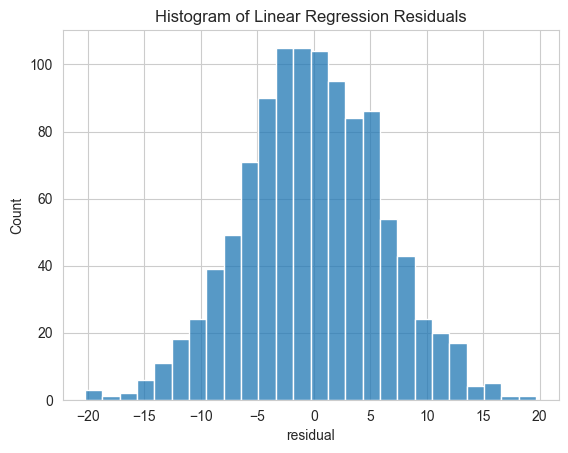

In [44]:
sns.histplot(data=results_df['residual'])
plt.title("Histogram of Linear Regression Residuals")

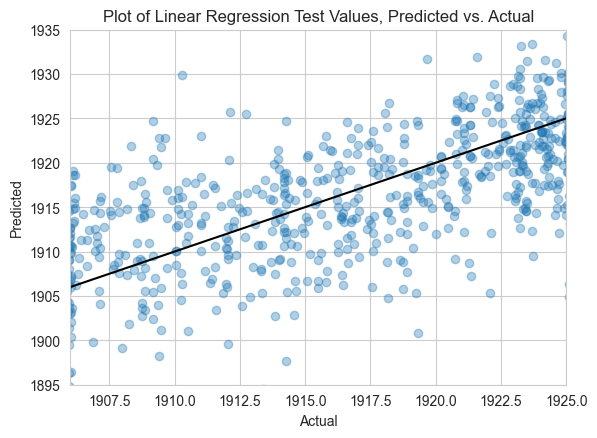

In [45]:
plt.xlim(1906, 1925)
plt.ylim(1895, 1935)
plt.scatter(results_df['actual'], results_df['predicted'], alpha=.35)
plt.plot([1895, 1935], [1895, 1935], color='black')
plt.title("Plot of Linear Regression Test Values, Predicted vs. Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.subplots_adjust(top=0.85)
plt.show()

## Intercept and coefficients

In [46]:
print(f"Intercept: {lr.intercept_}")

Intercept: 1909.2595927079494


In [48]:
features = SelectKBest(f_regression, k=5000).fit(tfidf_vectors, df['yearDecimal'])

selected = features.get_support()

features_df = pd.DataFrame()
features_df['term'] = dictionary_vectorizer.feature_names_
features_df['selected'] = selected
features_df = features_df.loc[features_df['selected'] == True]
features_df['coef'] = lr.coef_

coefficients = features_df.sort_values(by='coef', ascending=False).reset_index(drop=True)

In [51]:
coefficients.iloc[0:50]

,term,selected,coef
0,today,True,74.425442
1,colorful,True,43.981480
2,bring,True,39.510117
3,learn,True,37.496938
4,admitted,True,37.492291
5,department,True,37.301981
6,function,True,36.824999
7,mu,True,35.816388
8,phrase,True,34.728871
9,i,True,34.214467


In [50]:
coefficients.iloc[-25:]

,term,selected,coef
4975,lesson,True,-26.904964
4976,ts,True,-26.962745
4977,honest,True,-26.970281
4978,celtic,True,-27.243367
4979,reprinted,True,-27.879281
4980,purity,True,-27.974888
4981,interests,True,-28.271624
4982,practically,True,-28.555073
4983,recreation,True,-28.781961
4984,retain,True,-29.135714
